## 1. Introduction

Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.


There are 25 variables:
- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

## 2. Load packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb

pd.set_option('display.max_columns', 100)

## 3. Set parameters

Here we set few parameters for the analysis and models

In [2]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

## 4. Read the data

In [3]:
data_df = pd.read_csv("UCI_Credit_Card.csv")

In [4]:
data_df.shape

(30000, 25)

In [5]:
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Two columns ("PAY_0" and "default.payment.next.month") were poorly labelled, and we now proceed to rename them:

In [6]:
data_df = data_df.rename(columns={'default.payment.next.month': 'def_pay', 
                        'PAY_0': 'PAY_1'})
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Some observations:
- There are 30,000 distinct credit card clients.
- The average value for the amount of credit card limit is 167,484. The standard deviation is unusually large at 129,747, with the max value being 1 million.
- Education level is mainly skwered towards graduate school and university.
- Average age is 35.5 years, with a standard deviation of 9.2.
- As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that are expected to default in the next month (will verify this in the next sections of this analysis).


## 5. Check for missing data

In [8]:
total = data_df.isnull().sum().sort_values(ascending = False)
total

def_pay      0
PAY_6        0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
BILL_AMT1    0
PAY_AMT6     0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
ID           0
dtype: int64

We do not find any missing data in the entire dataset.

## 6. Checking for data imbalance

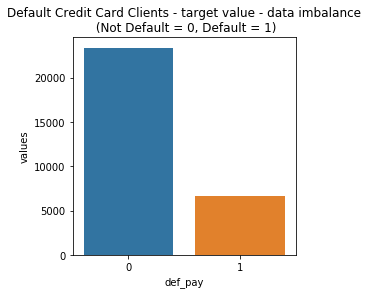

0    23364
1     6636
Name: def_pay, dtype: int64


In [9]:
temp = data_df["def_pay"].value_counts()
df = pd.DataFrame({'def_pay': temp.index,'values': temp.values})
plt.figure(figsize = (4,4))
plt.title('Default Credit Card Clients - target value - data imbalance\n (Not Default = 0, Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'def_pay', y="values", data=df)
locs, labels = plt.xticks()
plt.show()
print(temp)

6,636 out of 30,000 (or 22%) of clients are expected to default next month. 
This results in data imbalance of 22% default vs 78% non-default.  We will addresss this imbalance in a later section.

## 7. Data exploration

### 7.1 Credit card limit 

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


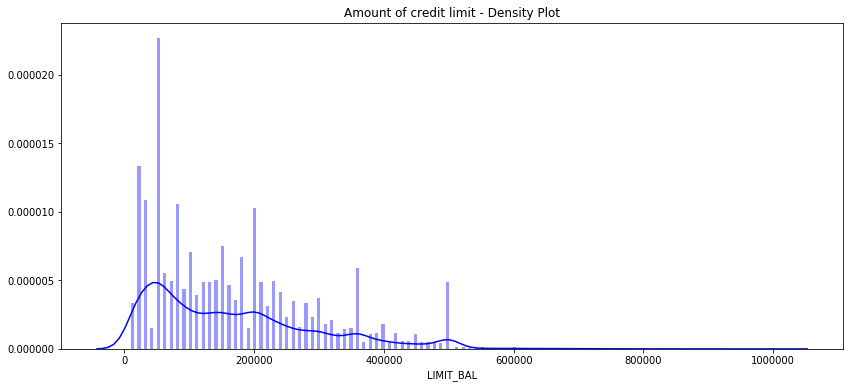

In [10]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data_df['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

In [11]:
data_df['LIMIT_BAL'].value_counts().shape

(81,)

In [12]:
data_df['LIMIT_BAL'].value_counts().head(5)

50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
Name: LIMIT_BAL, dtype: int64

In summary, there are 81 levels of credit card balance limit.  The most common limit is 50,000 (3365 instances), followed by 20,000 (1976) and 30,000 (1610).

### 7.2 Credit card limit grouped by expected defaults
Going through the data, we shall attempt to find out the credit card limit level that has the highest number of expected defaults.

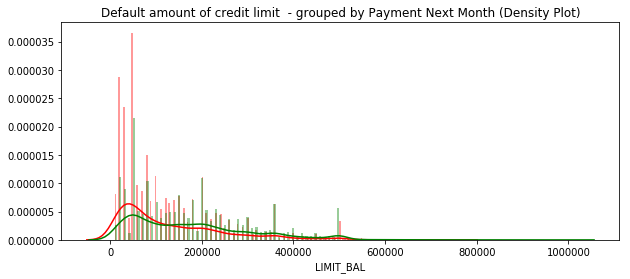

In [13]:
class_0 = data_df.loc[data_df['def_pay'] == 0]["LIMIT_BAL"]
class_1 = data_df.loc[data_df['def_pay'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (10,4))
plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)',fontsize=12)
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red", label="default next month")
sns.distplot(class_0,kde=True,bins=200, color="green", label="no default next month")
plt.show()

We find that majority of expected defaults are for credit card limits below 100,000, with the highest defaults expected in the 20,000 to 50,000 range, making this segment the riskist group of credit card holders. 

## 7.3 Sex, Education, Age and Marriage
We produce the box plots for age distribution grouped by marriage status and sex.

In [14]:
label_1 = ['unknown', 'married', 'single', 'others']

def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data_df, palette="PRGn",showfliers=False)
    s.set_xticklabels(label_1,rotation=0)
    plt.show();

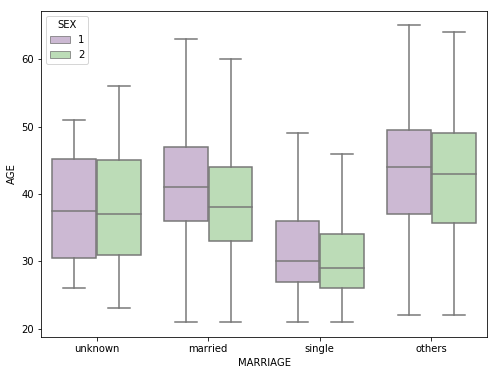

In [15]:
boxplot_variation('MARRIAGE','AGE', 'SEX',width=8)

Sex meaning is  defined as:

    1 : male
    2 : female

Generally we find that the male age is higher than female age, while married people have higher average age than unmarried people.  Others (vidowed or divorced) show the highest average age.  These age profiles appear to be reasonable. 

In [16]:
fil = (data_df['EDUCATION'] == 5) | (data_df['EDUCATION'] == 6) | (data_df['EDUCATION'] == 0)
data_df.loc[fil, 'EDUCATION'] = 4
data_df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [17]:
education = ['graduate school', 'university', 'high school', 'others']

def boxplot_variation2(feature1, feature2, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,4))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, 
                data=data_df, palette="PRGn",showfliers=False)
    s.set_xticklabels(education,rotation=0)
    plt.show();

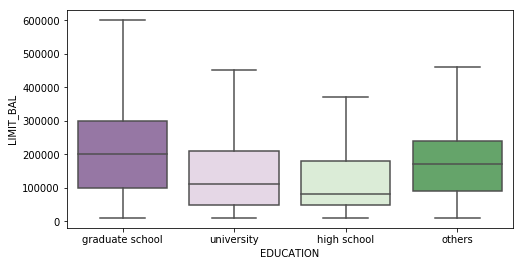

In [18]:
boxplot_variation2('EDUCATION','LIMIT_BAL',8)

Unsurprisingly, higher education status tends to result in higher credit card limits.

## 8. Decision Tree

In [19]:
#importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

In [20]:
# create the target variable
y = data_df['def_pay'].copy()
y.sample(5)

28040    0
12173    0
29856    0
10815    1
2358     0
Name: def_pay, dtype: int64

In [21]:
# create the features, which now will be everything in the original df
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = data_df[features].copy()
X.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [22]:
# split the df into train and test, it is important these two do not communicate during the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# this means we will train on 80% of the data and test on the remaining 20%

In [23]:
# hygiene check 
print(y_train.describe())
print("---------------------------")
print(y_test.describe())

count    24000.000000
mean         0.221792
std          0.415460
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: def_pay, dtype: float64
---------------------------
count    6000.000000
mean        0.218833
std         0.413490
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: def_pay, dtype: float64


In [24]:
#create the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# do our predictions on the test
predictions = classifier.predict(X_test)
print("Accuracy Score:")
# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

Accuracy Score:


0.8121666666666667

Using a simple Decision Tree Model, the model showed an 81% accuracy in forecasting the default of the credit card customers.
However, the data by nature is imbalanced:

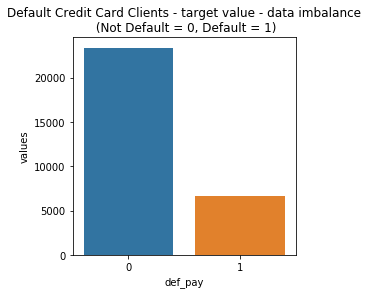

0    23364
1     6636
Name: def_pay, dtype: int64


In [25]:
temp = data_df["def_pay"].value_counts()
df = pd.DataFrame({'def_pay': temp.index,'values': temp.values})
plt.figure(figsize = (4,4))
plt.title('Default Credit Card Clients - target value - data imbalance\n (Not Default = 0, Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'def_pay', y="values", data=df)
locs, labels = plt.xticks()
plt.show()
print(temp)

The 81% model accuracy can be largely attributed to the majority class being 78% of the total data.

Therefore, we will demonstrate the upsampling method which scales the minority class (def_pay = 1) to the same size as the majority class (def_pay = 0).

In [26]:
# create the training df by remerging X_train and y_train
df_train = X_train.join(y_train)
df_train.sample(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
15044,390000.0,1,1,1,35,0,0,0,0,0,0,24297.0,28804.0,43996.0,47532.0,49414.0,51380.0,5000.0,20000.0,5006.0,5006.0,5008.0,3004.0,0
20616,50000.0,1,3,2,30,0,0,0,0,0,0,43702.0,44979.0,46755.0,47412.0,47703.0,49495.0,2000.0,2501.0,2000.0,2000.0,2500.0,2000.0,0
27133,500000.0,1,3,1,47,-1,-1,-1,-1,-1,0,1665.0,1665.0,1665.0,1665.0,8805.0,8764.0,1666.0,1666.0,1666.0,8806.0,1625.0,2808.0,0
20332,80000.0,2,3,2,54,0,0,2,0,0,0,16613.0,19828.0,19227.0,20593.0,20951.0,21460.0,3500.0,0.0,2000.0,1000.0,1000.0,1000.0,0
9941,30000.0,2,2,2,22,0,0,2,0,0,0,30397.0,31148.0,28755.0,30720.0,28298.0,9064.0,3500.0,0.0,3500.0,694.0,343.0,266.0,0
24462,340000.0,1,2,1,35,0,0,0,0,0,0,38214.0,39229.0,40747.0,41930.0,43397.0,44710.0,1500.0,2000.0,2000.0,2000.0,2000.0,2000.0,0
15511,200000.0,1,2,1,36,-1,-1,-1,-1,-1,-1,75.0,3707.0,697.0,0.0,2769.0,1382.0,3707.0,697.0,0.0,2769.0,1438.0,2411.0,0
7902,20000.0,2,2,1,40,0,0,0,0,0,0,14492.0,15304.0,16035.0,16517.0,16781.0,17142.0,1349.0,1080.0,562.0,500.0,456.0,218.0,1
27989,360000.0,2,2,1,30,0,0,-2,-2,-2,-2,19918.0,-182.0,-6877.0,-5377.0,-2377.0,-377.0,500.0,0.0,2000.0,3000.0,2000.0,3000.0,0
7382,180000.0,2,1,1,47,-1,-1,-1,-1,0,-1,807.0,4246.0,2727.0,5507.0,1382.0,538.0,4246.0,2727.0,5507.0,0.0,538.0,304.0,0


In [27]:
# Separate majority and minority classes
df_majority = df_train[df_train.def_pay==0]
df_minority = df_train[df_train.def_pay==1]

print(df_majority.def_pay.count())
print("-----------")
print(df_minority.def_pay.count())
print("-----------")
print(df_train.def_pay.value_counts())

18677
-----------
5323
-----------
0    18677
1     5323
Name: def_pay, dtype: int64


In [28]:
from sklearn.utils import resample

In [29]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=18677,    # to match majority class
                                 random_state=587) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Display new class counts
df_upsampled.def_pay.value_counts()

1    18677
0    18677
Name: def_pay, dtype: int64

In [30]:
# create the target variable
y = df_upsampled['def_pay'].copy()
y.sample(5)

7406     1
16888    0
24542    1
17472    0
27857    1
Name: def_pay, dtype: int64

In [31]:
# create the features, which now will be everything in the original df
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = df_upsampled[features].copy()
X.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
# hygiene check 
print(y_train.describe())
print("---------------------------")
print(y_test.describe())

count    29883.000000
mean         0.499615
std          0.500008
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: def_pay, dtype: float64
---------------------------
count    7471.000000
mean        0.501539
std         0.500031
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: def_pay, dtype: float64


In [34]:
#create the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# do our predictions on the test
predictions = classifier.predict(X_test)
print("Accuracy Score:")
# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

Accuracy Score:


0.7329674742337037

By applying the upsample method, we find that the model accuracy has been reduced from 81% to 73%, which is reasonable.  

Of note, the upsampling approach has the disadvantage of increasing the likelihood of overfitting, since it replicates the minority class event. It usually outperforms the downsampling method, which can discard potentially useful information, leading to sample bias.